efl               34.19
ffl              -3.774
pp1               30.42
bfl                20.5
ppk                13.7
f/#               3.419
m            -3.419e-09
red          -2.924e+08
obj_dist          1e+10
obj_ang            1.25
enp_dist             -0
enp_radius            5
na obj            5e-10
n obj                 1
img_dist           20.5
img_ht           0.7461
exp_dist         -289.3
exp_radius         45.3
na img          -0.1447
n img                 1
optical invariant       0.1091
              r            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1  2.1820e+08
    1:    65.220000      9.60000    N-SSK8             1      19.500
    2:   -62.030000      4.20000    N-SF10             1      19.500
    3: -1240.670000      10.0000       air             1      19.500
    4:   261.500000      2.50000   n:1.670             1      4.6148
    5:    70.067986      10.0000       air             1      4.5653
    6:   

TSA   -0.033125
TCO   -0.015460
TAS   -0.006471
SAS   -0.002760
PTB   -0.000904
DST   -0.000755
dtype: float64

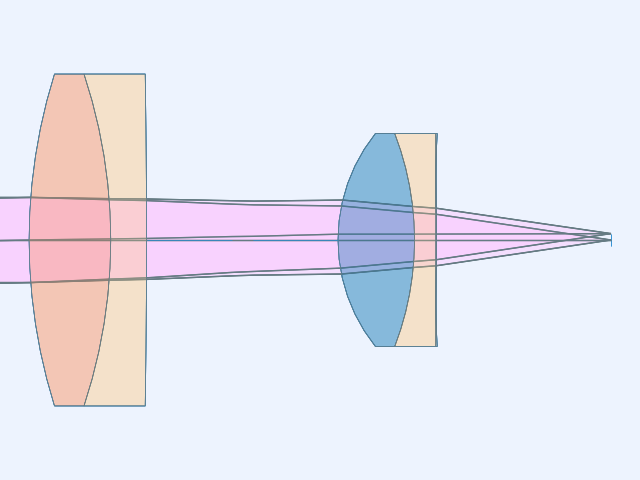

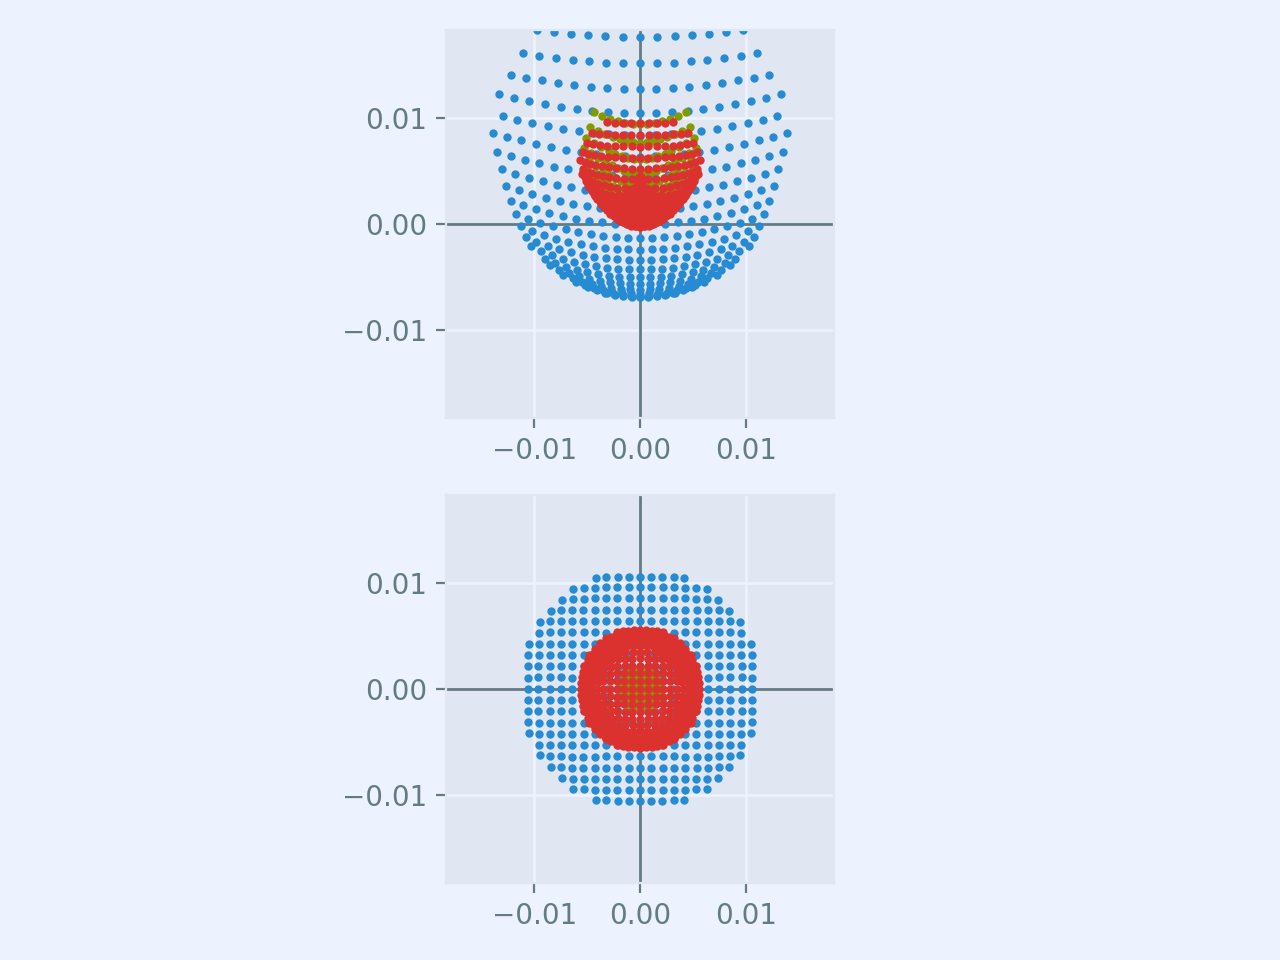

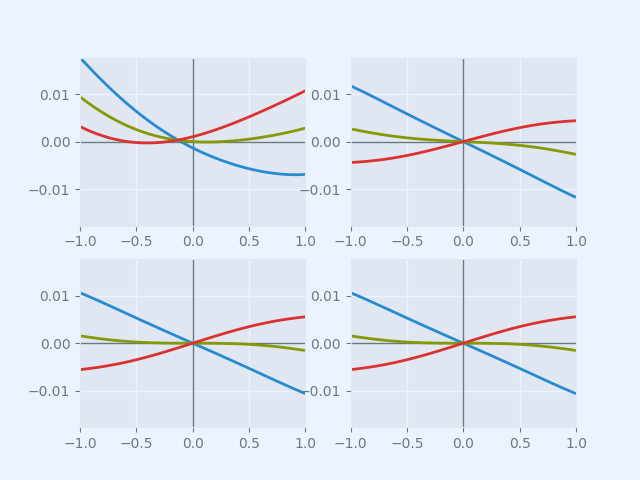

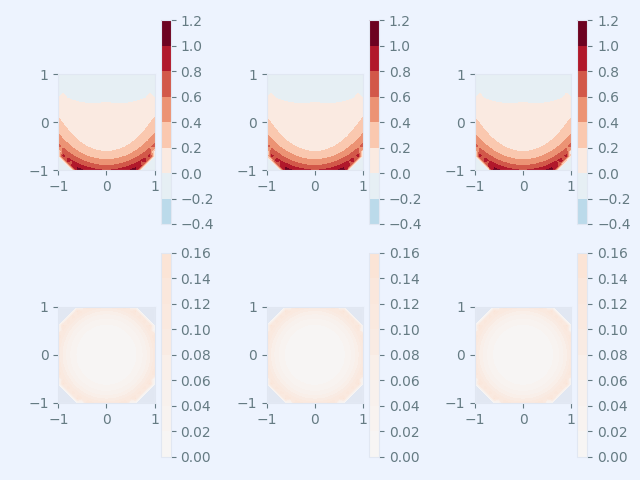

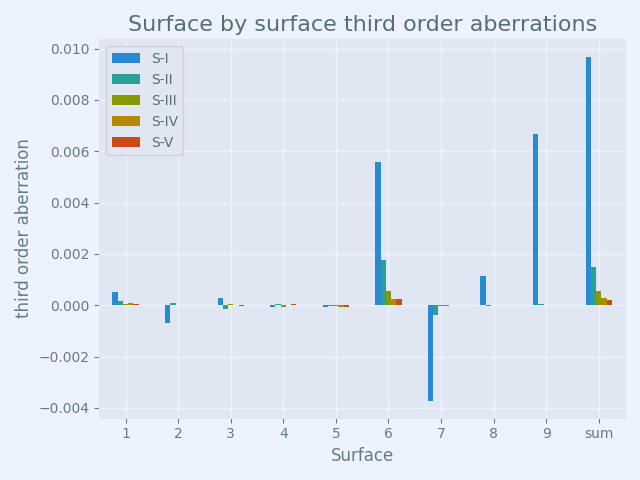

In [16]:
%matplotlib widget
isdark = False
from rayoptics.environment import *

def add_eyeglass_lens (sm, lens_diopter=-7.00, front_diopter=+2.00, thickness=2.50, r_index=1.67, abbe=42.0, gap=20):
    front_diopter = 2
    front_radius = (0.523 / front_diopter)
    back_radius = 1/((1/front_radius) - lens_diopter / (r_index-1))

    sm.add_surface([1000*front_radius, thickness, r_index], sd=30)
    sm.add_surface([1000*back_radius, gap], sd=30)



def SayaLens(gaps = [5,5,5], pupil=20, flds=[0,0.25]):
    opm = OpticalModel()
    opm.radius_mode = True
    
    osp = opm['optical_spec']
    osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=pupil)
    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=20.0, flds=flds, is_relative=True)
    osp['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)
    
    sm = opm['seq_model']    
    # Object distance
    sm.gaps[0].thi = 1e10
    
    #add_singlet_to_model('/Users/joshreich/src/lensStack/zmax_45169.zmx', gaps[0], opm) #50x200 DCX
    #opm.add_from_file('/Users/joshreich/src/lensStack/zmax_45169.zmx', t=gaps[0]) #50x200 DCX
    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_32921.zmx', t=gaps[1]) # 40x120 ACH                                     
#    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_47919.zmx', t=gaps[2]) # Eyeglass cutout :P
   
    add_eyeglass_lens(sm, gap=gaps[2])
    
    opm.add_from_file('/Users/joshreich/src/lensStack/zmax_49662.zmx', t=10) # 25x30 ASPH ACH VIS 0
    #opm.flip(opm['ele_model'].elements[8])
    
    opm.update_model()
    # Move the last element to the back focal length of the system
    sm.gaps[len(sm.gaps)-1].thi = opm['analysis_results']['parax_data'].fod.bfl 
    opm.update_model()
    
    return opm
    

SayaModel = SayaLens(gaps=[5,10,10], pupil=10)

pm = SayaModel['parax_model']
pm.first_order_data()

SayaModel['seq_model'].list_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=SayaModel, is_dark=isdark).plot()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=SayaModel,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=SayaModel, data_type='Ray', scale_type=Fit.All_Same, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=SayaModel,  scale_type=Fit.All_Same, is_dark=isdark).plot()

ar = SayaModel['analysis_results']
to_pkg = compute_third_order(SayaModel)
fig, ax = plt.subplots()
ax.set_xlabel('Surface')
ax.set_ylabel('third order aberration')
ax.set_title('Surface by surface third order aberrations')
to_pkg.plot.bar(ax=ax, rot=0)
ax.grid(True)
fig.tight_layout()


ax_ray, pr_ray, fod = ar['parax_data']
n_last = pm.sys[-1][mc.indx]
u_last = ax_ray[-1][mc.slp]
to.seidel_to_transverse_aberration(to_pkg.loc['sum',:], n_last, u_last)

In [17]:
SayaModel['seq_model'].ifcs

[Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy'),
 Surface(profile=Spherical(c=0.0153327200245324), interact_mode='transmit'),
 Surface(profile=Spherical(c=-0.016121231662099), interact_mode='transmit'),
 Surface(profile=Spherical(c=-0.000806016104201762), interact_mode='transmit'),
 Surface(profile=Spherical(c=0.0038240917782026767), interact_mode='transmit'),
 Surface(profile=Spherical(c=0.014271852972232527), interact_mode='transmit'),
 Surface(profile=Spherical(c=0.05), interact_mode='transmit'),
 Surface(profile=Spherical(c=-0.028735632183908), interact_mode='transmit'),
 Surface(profile=Spherical(c=0.0), interact_mode='transmit'),
 Surface(profile=EvenPolynomial(c=-0.004946958366111, cc=0.0, coefs=[0.0, 2.72236996481e-05, -4.97210167927e-08, 0.0, 0.0, 0.0, 0.0, 0.0]), interact_mode='transmit'),
 Surface(lbl='Img', profile=Spherical(c=0.0), interact_mode='dummy')]